<a href="https://colab.research.google.com/github/ferdinand1810/Metodos_Numericos_Aplicados_Ingenieria_UTEC/blob/main/CU_02_SplineCubic_NMPI_UTEC_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Paso 1: Instalar dependencias
!apt install tesseract-ocr -y > /dev/null
!pip install opencv-python-headless pytesseract numpy matplotlib --quiet

In [ ]:
# Paso 2: Subir imagen desde el equipo
from google.colab import files
from PIL import Image
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

uploaded = files.upload()

# Obtener nombre del archivo subido
for filename in uploaded.keys():
    imagen_path = filename

Saving regla_rio.jpg to regla_rio (1).jpg


✅ Nivel de agua aproximado: 0.3924 m


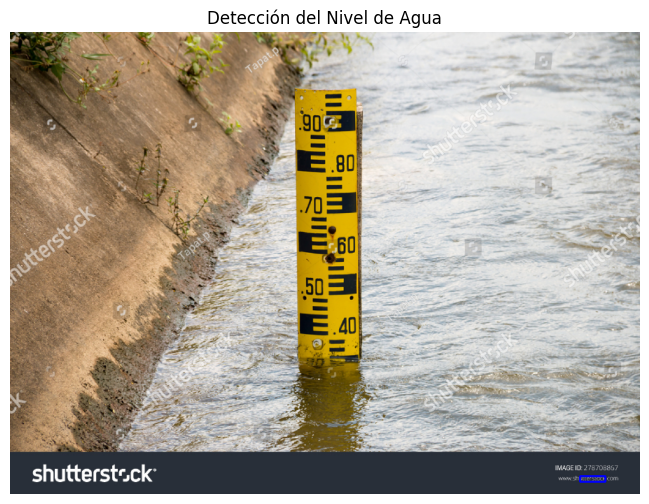

In [ ]:
# Paso 3: Procesar la imagen y detectar nivel de agua
img = cv2.imread(imagen_path)

# Validar si se cargó bien la imagen
if img is None:
    raise ValueError("❌ Error: No se pudo cargar la imagen. Verifica el nombre o formato.")

# Redimensionar (opcional para pruebas rápidas)
scale = 0.6
img = cv2.resize(img, None, fx=scale, fy=scale)

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Suavizado y bordes
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

# Detectar contornos
contornos, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Buscar línea horizontal del agua
nivel_y = None
for cnt in contornos:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30 and h < 15 and y > img.shape[0] * 0.5:
        nivel_y = y
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        break

# Estimar altura en la regla (marcas visibles: de 40 cm a 90 cm)
altura_aprox = None
if nivel_y:
    regla_top = int(img.shape[0] * 0.15)      # posición de 90 cm
    regla_bottom = int(img.shape[0] * 0.95)   # posición de 40 cm
    altura_total_pix = regla_bottom - regla_top
    altura_total_cm = 50  # rango visible en la regla

    altura_aprox = 90 - ((nivel_y - regla_top) / altura_total_pix * altura_total_cm)

    nivel_metros = round(altura_aprox / 100, 4)  # dos cifras significativas
    print(f"✅ Nivel de agua aproximado: {nivel_metros:.4f} m")
else:
    print("⚠️ No se detectó una línea de agua clara.")


# Mostrar resultado
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Detección del Nivel de Agua")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

# Datos de entrada
H = np.array([
    0.22, 0.25, 0.267, 0.285, 0.315, 0.45, 0.371, 0.39, 0.43,
    0.462, 0.483, 0.504, 0.538, 0.581, 0.589, 0.61, 0.63, 0.64
])
Q = np.array([
    1.1, 1.2, 1.3, 1.6, 2, 2.15, 2.62, 2.95, 3.8,
    4.08, 4.65, 4.85, 5.789, 6.2, 6.78, 6.89, 7.8, 7.9
])

# Ordenar por H
idx = np.argsort(H)
x = H[idx]
y = Q[idx]
n = len(x) - 1  # Número de intervalos

h = np.diff(x)

A = np.zeros((n - 1, n - 1))
B = np.zeros(n - 1)

# Llenar A y B para condiciones interiores
for i in range(1, n):
    A[i-1, i-1] = 2 * (h[i-1] + h[i])
    if i-2 >= 0:
        A[i-1, i-2] = h[i-1]
    if i < n - 1:
        A[i-1, i] = h[i]

    B[i-1] = 6 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

M_inner = np.linalg.solve(A, B)
M = np.concatenate(([0], M_inner, [0]))

a = y[:-1]
b = (y[1:] - y[:-1]) / h - (2*M[:-1] + M[1:]) * h / 6
c = M[:-1] / 2
d = (M[1:] - M[:-1]) / (6*h)

# Valor deseado
H_val = nivel_metros

# Buscar el intervalo en el que cae H_val
i = np.searchsorted(x, H_val) - 1
dx = H_val - x[i]

# Evaluar el polinomio
# Evaluar el polinomio
Q_val = a[i] + b[i]*dx + c[i]*dx**2 + d[i]*dx**3
print(f"Para H = {H_val}, el caudal estimado Q = {Q_val:.3f} m³/s")

Para H = 0.3924, el caudal estimado Q = 3.064 m³/s
